In [1]:
import numpy as np
import csv
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA

In [2]:
from sklearn import cluster

In [3]:
train_file = 'train.csv'
test_file  = 'test.csv'
user_median_file  = 'user_median.csv'
global_median_file = 'global_median.csv'
profiles_file = 'profiles.csv'
artists_file = 'artists.csv'
usr_art_file = 'usr-art_mat.csv'

# Artist data

In [4]:
artistsdf = pd.read_csv(artists_file)

In [5]:
artistsdf.head()

,artist,name
0,03098741-08b3-4dd7-b3f6-1b0bfa2c879c,Liars
1,69c4cc43-8163-41c5-ac81-30946d27bb69,CunninLynguists
2,7a2e6b55-f149-4e74-be6a-30a1b1a387bb,The Desert Sessions
3,7002bf88-1269-4965-a772-4ba1e7a91eaa,Glenn Gould
4,dbf7c761-e332-467b-b4d9-aafe06bbcf8f,G. Love & Special Sauce


In [6]:
artists = artistsdf['artist']

# Read in full training data

In [7]:
inputdf = pd.read_csv(train_file)

In [8]:
traindf = inputdf.pivot(index='user', columns='artist', values='plays')

In [9]:
traindf.reset_index(inplace=True)

In [10]:
train_users = traindf['user']

In [11]:
traindfpc = pd.read_pickle('trainpcs.pkl')

In [12]:
merge_traindf = pd.read_pickle('merge_traindf.pkl')

In [13]:
merge_users = merge_traindf['user']
merge_traindf = merge_traindf.drop('user', 1)

# Read in split train/validate data

In [14]:
X_train = pd.read_pickle('Xtrain.pkl')

In [16]:
X_valid = pd.read_pickle('Xvalid.pkl')

In [17]:
X_traindfpc = pd.read_pickle('Xtrainpcs.pkl')

In [18]:
Xmerge_traindf = pd.read_pickle('Xmerge_traindf.pkl')

In [19]:
Xmerge_users = Xmerge_traindf['user']
Xmerge_traindf = Xmerge_traindf.drop('user', 1)

In [20]:
Xmerge_traindf.shape

(233286, 20)

# K Means

In [22]:
K = 10

In [22]:
%%time
k_means = cluster.KMeans(n_clusters=K, init='k-means++')
k_means.fit(merge_traindf)

CPU times: user 42.9 s, sys: 3.75 s, total: 46.6 s
Wall time: 40.4 s


In [23]:
k_means.labels_

array([7, 1, 4, ..., 7, 1, 1], dtype=int32)

In [105]:
%%time
dbs = cluster.DBSCAN()
dbs.fit(merge_traindf)

CPU times: user 20min 59s, sys: 4.51 s, total: 21min 3s
Wall time: 21min 4s


### for split data

In [23]:
%%time
Xk_means = cluster.KMeans(n_clusters=K, init='k-means++')
Xk_means.fit(Xmerge_traindf)

CPU times: user 35.1 s, sys: 3.09 s, total: 38.2 s
Wall time: 31.5 s


In [24]:
Xk_means.labels_

array([0, 1, 8, ..., 0, 1, 1], dtype=int32)

In [53]:
%%time
dbs = cluster.DBSCAN()
dbs.fit(Xmerge_traindf)

CPU times: user 23min 20s, sys: 24.3 s, total: 23min 44s
Wall time: 24min 1s


In [54]:
dbs.labels_

array([ 0, -1,  1, ..., -1, -1, -1])

In [55]:
len(dbs.labels_)

233286

# Prediction

The idea is to use the median number of plays for a given artist across users in a given cluster. So if my cluster label is 1, I'm predicted to listen to "Kanye West" equal to the median number of plays of Kanye West for people in cluster 1.

In [106]:
user_labels = dict(zip(merge_users, dbs.labels_))

In [107]:
summary_df = pd.DataFrame.from_dict(user_labels, orient='index')

In [108]:
summary_df.reset_index(inplace=True)

In [109]:
summary_df.columns = ['user', 'label']

In [110]:
summary_df = pd.merge(inputdf, summary_df, on='user')

In [111]:
summary_labelgroup = summary_df.groupby(['label', 'artist'])

In [112]:
summary_labelonly = summary_df.groupby('label')

In [113]:
group_mediansdf = summary_labelgroup.median()

In [114]:
group_labelonly_meds_df = summary_labelonly.median()

In [115]:
group_mediansdf.reset_index(inplace=True)

In [116]:
group_mediansdf.head()

,label,artist,plays
0,-1,000d90ec-d64c-48a1-b775-e726fd240e9f,199.0
1,-1,000fc734-b7e1-4a01-92d1-f544261b43f5,249.5
2,-1,0019749d-ee29-4a5f-ab17-6bfa11deb969,160.0
3,-1,0039c7ae-e1a7-4a7d-9b49-0cbc716821a6,308.0
4,-1,004e5eed-e267-46ea-b504-54526f1f377d,290.0


convert to nested dictionary

In [117]:
def recur_dictify(frame):
    if len(frame.columns) == 1:
        if frame.values.size == 1: return frame.values[0][0]
        return frame.values.squeeze()
    grouped = frame.groupby(frame.columns[0])
    d = {k: recur_dictify(g.ix[:,1:]) for k,g in grouped}
    return d

In [118]:
group_medians_dict = recur_dictify(group_mediansdf)

In [119]:
group_labelonly_meds_df.reset_index(inplace=True)

In [120]:
label_medians = dict(zip(group_labelonly_meds_df.label, group_labelonly_meds_df.plays))

### for split data

In [56]:
Xuser_labels = dict(zip(Xmerge_users, dbs.labels_))

In [57]:
Xsummary_df = pd.DataFrame.from_dict(Xuser_labels, orient='index')

In [58]:
Xsummary_df.reset_index(inplace=True)
Xsummary_df.columns = ['user', 'label']

In [59]:
Xsummary_df.shape

(233286, 2)

In [60]:
Xsummary_df = pd.merge(X_train, Xsummary_df, on='user')

In [61]:
Xsummary_labelgroup = Xsummary_df.groupby(['label', 'artist'])
Xsummary_labelonly = Xsummary_df.groupby('label')
Xgroup_mediansdf = Xsummary_labelgroup.median()
Xgroup_labelonly_meds_df = Xsummary_labelonly.median()

In [62]:
Xgroup_mediansdf.reset_index(inplace=True)

In [63]:
Xgroup_medians_dict = recur_dictify(Xgroup_mediansdf)

In [64]:
Xgroup_labelonly_meds_df.reset_index(inplace=True)

In [65]:
Xlabel_medians = dict(zip(Xgroup_labelonly_meds_df.label, Xgroup_labelonly_meds_df.plays))

# Get the user medians

In [38]:
# Load the training data.

# new: partition into training and validation set
# if we want to use all data for training? just set rMax to > 5M
rMax = 6000000 # use first 3M to populate training matrix; after that, test
r = 0
idx = 1

train_data = {}
test_data = {}
with open(train_file, 'r') as train_fh:
    train_csv = csv.reader(train_fh, delimiter=',', quotechar='"')
    next(train_csv, None)

    for row in train_csv:
        user   = row[0]
        artist = row[1]
        plays  = row[2]
        
        if r<rMax: # then populate training data
            if not user in train_data:
                train_data[user] = {}
        
            train_data[user][artist] = int(plays)
            r = r+1
        else: # else populate validation set
            test_data[idx] = [user, artist, plays] # with valid set: now how extra entry for real # of plays
            idx = idx+1

In [39]:
# Compute the global median and per-user median.
plays_array  = []
user_medians = {}
for user, user_data in train_data.iteritems():
    user_plays = []
    for artist, plays in user_data.iteritems():
        plays_array.append(plays)
        user_plays.append(plays)

    user_medians[user] = np.median(np.array(user_plays))
global_median = np.median(np.array(plays_array))

# Write solutions

In [132]:
soln_file = 'final_test4.csv'

# Write out test solutions.
with open(test_file, 'r') as test_fh:
    test_csv = csv.reader(test_fh, delimiter=',', quotechar='"')
    next(test_csv, None)

    with open(soln_file, 'w') as soln_fh:
        soln_csv = csv.writer(soln_fh,
                              delimiter=',',
                              quotechar='"',
                              quoting=csv.QUOTE_MINIMAL)
        soln_csv.writerow(['Id', 'plays'])

        for row in test_csv:
            id     = row[0]
            user   = row[1]
            artist = row[2]

            if user in user_medians:
                try:
                    label = user_labels[user]
                    artist_median = group_medians_dict[label][artist]
                    cluster_median = label_medians[label]
                    ratio = artist_median/cluster_median
                    prediction = user_medians[user]*(ratio)
                    if (ratio < 0.5) or (ratio > 2):
                        prediction = user_medians[user]*(artist_median/cluster_median)
                        #prediction = np.mean([user_medians[user],artist_median])
                    else:
                        prediction = user_medians[user]
                    soln_csv.writerow([id, prediction])
                except:
                    soln_csv.writerow([id, 0]) # if the artist isn't in the user's cluster, assume 0 plays
            else:
                print "User", id, "not in training data."
                soln_csv.writerow([id, global_median])

In [133]:
solutions = pd.read_csv(soln_file)

In [134]:
solutions

,Id,plays
0,1,72.5
1,2,143.5
2,3,207.0
3,4,307.0
4,5,109.0
5,6,124.0
6,7,336.0
7,8,118.0
8,9,443.5
9,10,148.0


In [124]:
median_solns = pd.read_csv(user_median_file)

In [125]:
median_solns

,Id,plays
0,1,72.5
1,2,143.5
2,3,207.0
3,4,307.0
4,5,109.0
5,6,124.0
6,7,336.0
7,8,118.0
8,9,443.5
9,10,148.0


In [173]:
solutions.equals(median_solns)

False

In [146]:
np.mean(solutions['plays'])

172.6629472774167

In [147]:
np.mean(median_solns['plays'])

173.67259273843

In [202]:
np.mean(solutions['plays'])

166.3279991667477

In [210]:
np.mean(solutions['plays'])

183.65755810234847

# Validation

In [40]:
X_validdf = X_valid

In [41]:
X_validdf.head()

,user,artist,plays
1801118,8733e2c35fe392fc0dd1f668b65db4db78f74415,f181961b-20f7-459e-89de-920ef03c7ed0,12
266003,60ecc29bc69d0772e1d686ce30eb3fa449e3daff,148ddea2-6839-4354-8e2c-5dfadf136b7f,8
461155,649df765a64f6fcda204342cddc59de0ef4ee19a,321531fc-db73-4ffa-a959-61a61a2908c1,118
4121877,34f960c24eb12fa8b77ec9ce7a73dd2d9b360c1f,023d64c9-93db-4a20-8c5c-2efa1a53481a,33
1348685,ffc74d91ff215686c57d2c9df4af1601f7eca420,d8d1b067-78bb-4db7-8f91-db2ff9a83ee5,567


In [42]:
X_validdf.reset_index(inplace=True)
X_validdf.head()

,index,user,artist,plays
0,1801118,8733e2c35fe392fc0dd1f668b65db4db78f74415,f181961b-20f7-459e-89de-920ef03c7ed0,12
1,266003,60ecc29bc69d0772e1d686ce30eb3fa449e3daff,148ddea2-6839-4354-8e2c-5dfadf136b7f,8
2,461155,649df765a64f6fcda204342cddc59de0ef4ee19a,321531fc-db73-4ffa-a959-61a61a2908c1,118
3,4121877,34f960c24eb12fa8b77ec9ce7a73dd2d9b360c1f,023d64c9-93db-4a20-8c5c-2efa1a53481a,33
4,1348685,ffc74d91ff215686c57d2c9df4af1601f7eca420,d8d1b067-78bb-4db7-8f91-db2ff9a83ee5,567


In [43]:
X_validdf = X_validdf.drop('index', 1)
#X_validdf = X_validdf.drop('level_0', 1)
X_validdf.head()

,user,artist,plays
0,8733e2c35fe392fc0dd1f668b65db4db78f74415,f181961b-20f7-459e-89de-920ef03c7ed0,12
1,60ecc29bc69d0772e1d686ce30eb3fa449e3daff,148ddea2-6839-4354-8e2c-5dfadf136b7f,8
2,649df765a64f6fcda204342cddc59de0ef4ee19a,321531fc-db73-4ffa-a959-61a61a2908c1,118
3,34f960c24eb12fa8b77ec9ce7a73dd2d9b360c1f,023d64c9-93db-4a20-8c5c-2efa1a53481a,33
4,ffc74d91ff215686c57d2c9df4af1601f7eca420,d8d1b067-78bb-4db7-8f91-db2ff9a83ee5,567


In [44]:
X_validdf.to_csv('X_valid.csv')

In [94]:
#X_validreadtest = pd.read_csv('X_valid.csv')

In [126]:
soln_file = 'valid_test2.csv'

# Write out test solutions.
with open('X_valid.csv', 'r') as valid_fh:
    valid_csv = csv.reader(valid_fh, delimiter=',', quotechar='"')
    next(valid_csv, None)

    with open(soln_file, 'w') as soln_fh:
        soln_csv = csv.writer(soln_fh,
                              delimiter=',',
                              quotechar='"',
                              quoting=csv.QUOTE_MINIMAL)
        soln_csv.writerow(['Id', 'artist_median', 'cluster_median', 'prediction', 'median', 'true'])

        for row in valid_csv:
            id     = row[0]
            user   = row[1]
            artist = row[2]
            true   = row[3]

            if user in user_medians:
                try:
                    label = Xuser_labels[user]
                    artist_median = Xgroup_medians_dict[label][artist]
                    cluster_median = Xlabel_medians[label]
                    ratio = artist_median/cluster_median
                    if (ratio < 0.5) or (ratio > 2):
                        prediction = user_medians[user]*(artist_median/cluster_median)
                        #prediction = np.mean([user_medians[user],artist_median])
                    else:
                        prediction = user_medians[user]
                    soln_csv.writerow([id, artist_median, cluster_median, prediction, user_medians[user], true])
                except:
                    soln_csv.writerow([id, artist_median, cluster_median, 0, user_medians[user], true]) # if the artist isn't in the user's cluster, assume 0 plays
            else:
                soln_csv.writerow([id, artist_median, cluster_median, global_median, user_medians[user], true])

In [127]:
validations = pd.read_csv(soln_file)

In [128]:
validations.head(50)

,Id,artist_median,cluster_median,prediction,median,true
0,0,46.5,46,15.000000,15.0,12
1,1,58.0,54,21.000000,21.0,8
2,2,194.0,240,146.000000,146.0,118
3,3,44.0,41,35.500000,35.5,33
4,4,312.0,240,543.500000,543.5,567
5,5,71.0,54,21.000000,21.0,161
6,6,77.5,57,13.000000,13.0,14
7,7,58.0,66,28.000000,28.0,28
8,8,50.5,54,258.500000,258.5,283
9,9,86.0,54,60.000000,60.0,23


In [101]:
validations['true'].describe()

count    1246442.000000
mean         252.375287
std          632.118485
min            1.000000
25%           48.000000
50%          118.000000
75%          264.000000
max       179843.000000
Name: true, dtype: float64

In [102]:
validations['median'].describe()

count    1246442.000000
mean         173.084586
std          220.751441
min            1.000000
25%           48.000000
50%          109.000000
75%          218.000000
max        11236.000000
Name: median, dtype: float64

In [103]:
validations['artist_median'].describe()

count    1246442.000000
mean         146.253624
std          101.959905
min            1.000000
25%           54.000000
50%           89.000000
75%          240.000000
max         3188.000000
Name: artist_median, dtype: float64

In [104]:
validations['cluster_median'].describe()

count    1246442.000000
mean         140.783558
std           92.617971
min           14.000000
25%           54.000000
50%           69.000000
75%          240.000000
max          305.000000
Name: cluster_median, dtype: float64

In [95]:
%matplotlib inline
import matplotlib.pyplot as plt

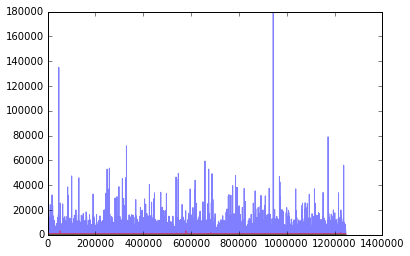

In [100]:
plt.plot(range(len(validations)), validations['true'], alpha=0.5, color='blue')
plt.plot(range(len(validations)), validations['artist_median'], alpha=0.5, color='red')
plt.plot(range(len(validations)), validations['cluster_median'], alpha=0.5, color='green')
plt.show()

In [129]:
validations['diff'] = abs(validations['true']-validations['prediction'])

In [130]:
diff_sum = np.sum(validations['diff'])

In [131]:
diff_sum/validations.shape[0]

129.7633769475384

In [86]:
diff_sum/validations.shape[0]

129.7633769475384

In [79]:
diff_sum/validations.shape[0]

142.0101194038712

In [71]:
diff_sum/validations.shape[0]

131.4680875430356

In [80]:
validations['meddiff'] = abs(validations['true']-validations['median'])
diff_sum = np.sum(validations['meddiff'])
diff_sum/validations.shape[0]

128.64863507487712